In [2]:
# Kütüphanelerin dahil edilmesi
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pandas as pd

In [5]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
# Veri setinin özellikler ve hedef değişken olarak ayrılması.
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [9]:
# Veri setinin eğitim ve test olarak ayrılması.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,stratify=y, random_state=13)

In [10]:
# Random Forest sınıflandırıcısının oluşturulması.

randomForest_cls = RandomForestClassifier(max_features=2, n_estimators=100, bootstrap=True)
randomForest_cls.fit(X_train, y_train)

RandomForestClassifier(max_features=2)

In [11]:
# Test veri seti üzerinden tahmin yapılması.
y_pred = randomForest_cls.predict(X_test)

In [12]:
# Tahmin Raporu
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       150
           1       0.76      0.62      0.68        81

    accuracy                           0.80       231
   macro avg       0.78      0.76      0.77       231
weighted avg       0.79      0.80      0.79       231



In [13]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[134  16]
 [ 31  50]]


In [14]:
# Accuracy Score
print(accuracy_score(y_test, y_pred))

0.7965367965367965


# SHAP

In [15]:
import shap
import matplotlib.pyplot as plt

#### TreeExplainer sınıfının rastgele orman sınıflandırıcısıyla başlatılmasının ardından, test veri kümesindeki her örneğin her özelliği için şekil değerleri hesaplanır.

In [17]:
# SHAP açıklayıcısını oluştrulması.

explainer = shap.TreeExplainer(randomForest_cls) # Açıklayıcı nesnenin oluşturulması.
shap_values = explainer.shap_values(X_test) # SHAP değerlerinin hesaplanması.

Değişken Önem Grafiği - Küresel Yorumlama


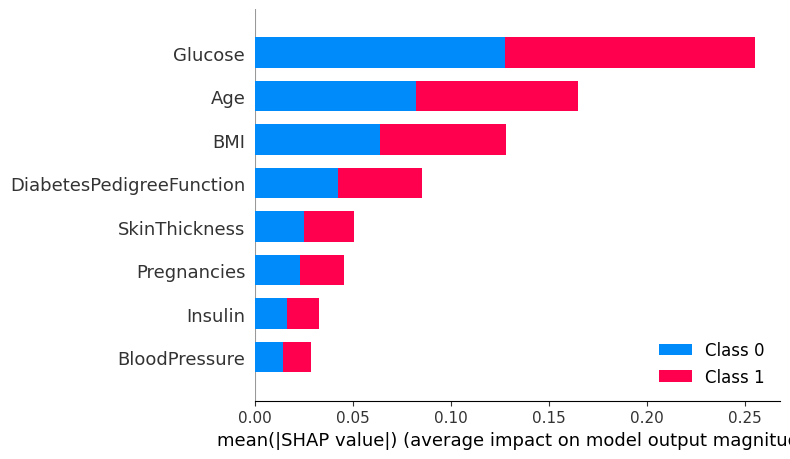

In [18]:
print("Değişken Önem Grafiği - Küresel Yorumlama")
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### *Kırmızı ve mavi renklerin her sınıf için yatay dikdörtgenlerin yarısını kapladığını görebiliyoruz. Bu, her özelliğin hem diyabet (etiket=1) hem de diyabet dışı (etiket=0) vakaların sınıflandırılmasında eşit etkiye sahip olduğu anlamına gelir.
#### *Ancak Glikoz, Yaş ve BMI en fazla tahmin gücüne sahip ilk üç özelliktir.
#### *Öte yandan Gebelik, Cilt Kalınlığı, İnsülin ve Kan Basıncı ilk üç özellik kadar katkı sağlamamaktadır.

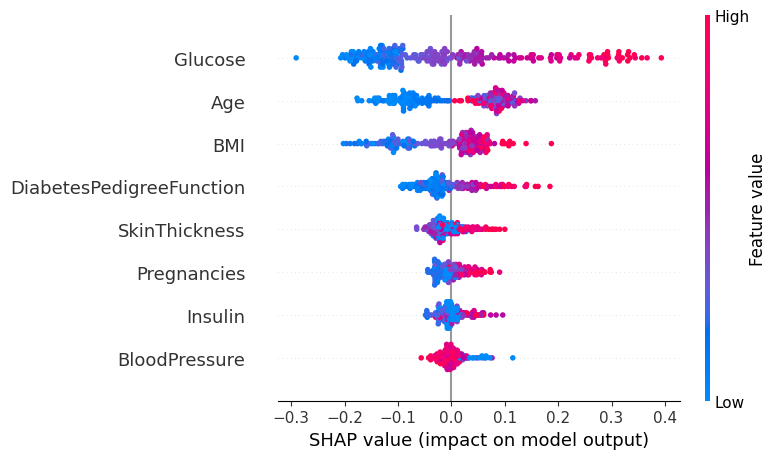

In [20]:
# Belirli Bir Etiketin Özet Grafiği
"""Bu yaklaşımı kullanmak, her özelliğin belirli bir sonuç (etiket) üzerindeki etkisine ilişkin daha ayrıntılı bir genel bakış sağlayabilir.
Aşağıdaki örnekte shap_values[1], etiket 1 olarak sınıflandırılan (diyabet hastası) örnekler için SHAP değerlerini temsil etmek üzere kullanılmıştır."""

shap.summary_plot(shap_values[1], X_test)

*Y ekseni, görüntü 2'deki grafiğe benzer şekilde, ortalama mutlak SHAP değerlerine göre sıralanan özellikleri temsil eder.

*X ekseni SHAP değerlerini temsil eder. Belirli bir özelliğe ilişkin pozitif değerler, modelin tahminini incelenen etikete (etiket=1) yaklaştırır. Bunun tersine, negatif değerler karşıt sınıfa doğru itilir (etiket=0).

*Yüksek glikoz (kırmızı noktalar) seviyesine sahip bir kişiye muhtemelen diyabet tanısı konacaktır (pozitif sonuç), düşük glikoz seviyesi ise diyabet tanısı konulamamasına yol açacaktır.

*Benzer şekilde, yaşlanan hastaların diyabet tanısı alma olasılığı daha yüksektir. Ancak model genç hastaların tanısı konusunda belirsiz görünüyor.

*Yaş özelliği için bu belirsizlikle baş etmenin bir yolu, daha fazla bilgi edinmek için bağımlılık grafiğini kullanmaktır.

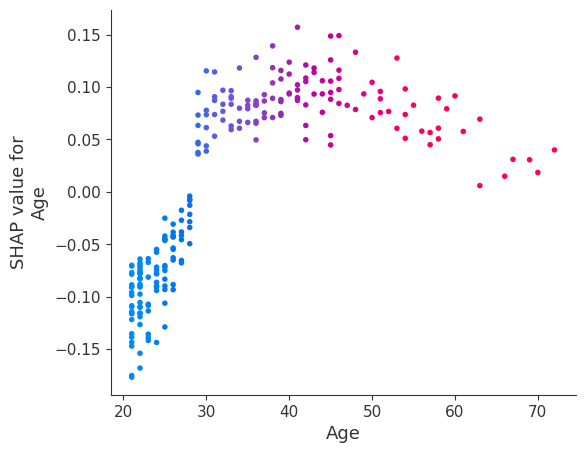

In [22]:
# Bağımlılık Grafikleri

"""Özet grafiklerden farklı olarak bağımlılık grafikleri, 
belirli bir özellik ile veri içindeki her bir örnek için tahmin edilen sonuç arasındaki ilişkiyi gösterir. 
Bu analiz birçok nedenden dolayı gerçekleştirilir 
ve daha ayrıntılı bilgi elde etmek ve özet grafiklerden veya diğer küresel özellik önemi ölçümlerinden elde edilen bulguları 
doğrulayarak veya bunlara karşı çıkarak analiz edilen özelliğin önemini doğrulamakla sınırlı değildir. """

shap.dependence_plot("Age", shap_values[1], X_test, interaction_index="Age")


#### Bağımlılık grafiği, 30 yaşın altındaki hastaların diyabet tanısı alma riskinin daha düşük olduğunu ortaya koyuyor. Buna karşılık, 30 yaşın üzerindeki bireylerin diyabet tanısı alma olasılığı daha yüksektir.